In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Final_lightRail_dataset.csv to Final_lightRail_dataset.csv


In [ ]:
data = pd.read_csv('Final_lightRail_dataset.csv')
df = pd.DataFrame(data)

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58282 entries, 0 to 58281
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ZIP                   58282 non-null  int64  
 1   Year                  58282 non-null  int64  
 2   HPI                   45196 non-null  float64
 3   Median_Value          45377 non-null  float64
 4   EstablishmentCount    58282 non-null  int64  
 5   Establishment_Sector  58282 non-null  object 
 6   Business_Density      49279 non-null  float64
 7   Log_Business_Density  49279 non-null  float64
 8   Pre_Impl_Indicator    58282 non-null  int64  
 9   Impl_phase_Indicator  58282 non-null  int64  
 10  Post_Impl_Indicator   58282 non-null  int64  
 11  COVID_Indicator       58282 non-null  int64  
 12  Crisis2008_Indicator  58282 non-null  int64  
 13  Adjacency_Indicator   58282 non-null  int64  
 14  Rail_Distance_Miles   58282 non-null  float64
 15  Log_Median_Value   

In [ ]:
df.dropna(inplace=True)

In [ ]:
df = df[df['Establishment_Sector'] != 'Total_Establishments'].copy()

In [ ]:
treatment_zips = df[df['Adjacency_Indicator'] == 1]['ZIP'].unique()
df['Treatment_Group'] = df['ZIP'].isin(treatment_zips).astype(int)

In [ ]:
df['DID_Impl'] = df['Treatment_Group'] * df['Impl_phase_Indicator']
df['DID_Post'] = df['Treatment_Group'] * df['Post_Impl_Indicator']

In [ ]:
df['Time'] = df['Year'] - 2000

In [ ]:
def fit_ols_cluster(formula, data, cluster_col='ZIP'):
    """Fits OLS model with clustered standard errors."""
    model = smf.ols(formula=formula, data=data)
    res = model.fit(cov_type='cluster', cov_kwds={'groups': data[cluster_col]})
    return res

def analyze_did_model(res, outcome_name):
    """Prints summary, joint test, and comparison test for DID results."""
    print(f"\nAnalysis: {outcome_name}")
    print(res.summary())

    did_terms = ['DID_Impl', 'DID_Post']

    # Joint Test
    restrictions = ','.join([f"{t} = 0" for t in did_terms])
    ftest = res.f_test(restrictions)
    print("\nJoint Test (Impl and Post)")
    print(ftest)

    # Comparison Test
    print("\nComparison Test (Post vs Impl)")
    restrictions = "DID_Post - DID_Impl = 0"
    t_test = res.t_test(restrictions)
    print(t_test)

group_time_trend = 'Treatment_Group:Time'
# Define controls once
controls = 'COVID_Indicator + Crisis2008_Indicator'
# Base formula with Fixed Effects
base_formula = f'DID_Impl + DID_Post + {controls} + C(ZIP) + C(Year) + {group_time_trend}'

In [ ]:
outcomes = {
    'Log_Median_Value': 'A1: Log_Median_Value (Testing H0a)',
    'Log_HPI': 'A2: Log_HPI (Robustness Check)',
    'Log_Business_Density': 'B: Log_Business_Density (Testing H0b)'
}

results_did = {}

for dep_var, title in outcomes.items():
    formula = f'{dep_var} ~ {base_formula}'
    res = fit_ols_cluster(formula, df)
    results_did[dep_var] = res
    analyze_did_model(res, title)



Analysis: A1: Log_Median_Value (Testing H0a)
                            OLS Regression Results                            
Dep. Variable:       Log_Median_Value   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     4732.
Date:                Fri, 14 Nov 2025   Prob (F-statistic):          1.83e-164
Time:                        00:28:11   Log-Likelihood:                 41389.
No. Observations:               45196   AIC:                        -8.249e+04
Df Residuals:                   45052   BIC:                        -8.123e+04
Df Model:                         143                                         
Covariance Type:              cluster                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 145, but rank is 26
  warnings.warn('covariance of constraints does not have full '



Analysis: A2: Log_HPI (Robustness Check)


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 145, but rank is 26
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                Log_HPI   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     4646.
Date:                Fri, 14 Nov 2025   Prob (F-statistic):          5.36e-164
Time:                        00:28:14   Log-Likelihood:                 45248.
No. Observations:               45196   AIC:                        -9.021e+04
Df Residuals:                   45052   BIC:                        -8.895e+04
Df Model:                         143                                         
Covariance Type:              cluster                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.3729 

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 145, but rank is 26
  warnings.warn('covariance of constraints does not have full '


In [ ]:
df['Establishment_Sector'] = df['Establishment_Sector'].replace({'etail_Trade': 'Retail_Trade'})

hypothesis_sectors = ['Retail_Trade', 'Accommodation_Food_Services']
reference_sector = 'Professional_Services'

df_h1d = df[
    df['Establishment_Sector'].isin(hypothesis_sectors + [reference_sector])
].copy()

# create Dummy variables
df_h1d['Retail_Dummy'] = (df_h1d['Establishment_Sector'] == 'Retail_Trade').astype(int)
df_h1d['Food_Service_Dummy'] = (df_h1d['Establishment_Sector'] == 'Accommodation_Food_Services').astype(int)

df_h1d['DDD_Retail_Impl'] = df_h1d['DID_Impl'] * df_h1d['Retail_Dummy']
df_h1d['DDD_Retail_Post'] = df_h1d['DID_Post'] * df_h1d['Retail_Dummy']
df_h1d['DDD_Food_Impl'] = df_h1d['DID_Impl'] * df_h1d['Food_Service_Dummy']
df_h1d['DDD_Food_Post'] = df_h1d['DID_Post'] * df_h1d['Food_Service_Dummy']

# define formula_h1d
formula_h1d = (
    'Log_Business_Density ~ '
    'Retail_Dummy + Food_Service_Dummy + '
    'DDD_Retail_Impl + DDD_Retail_Post + '
    'DDD_Food_Impl + DDD_Food_Post + '
    f'{controls} + C(ZIP) + C(Year)'
)


res_h1d = fit_ols_cluster(formula_h1d, df_h1d)
print("\nDDD Model: Retail & Food Service vs. Professional Services")
print(res_h1d.summary())
h1d_terms = ['DDD_Retail_Impl', 'DDD_Retail_Post', 'DDD_Food_Impl', 'DDD_Food_Post']

#joint test logic
restrictions = ','.join([f"{t} = 0" for t in h1d_terms])
ftest = res_h1d.f_test(restrictions)
print("\nJoint test for DDD Terms")
print(ftest)

results_table = res_h1d.summary().tables[1]
df_results = pd.DataFrame(results_table.data[1:], columns=results_table.data[0])
df_results.to_csv("DDD_Coefficients_Table.csv", index=False)


DDD Model: Retail & Food Service vs. Professional Services
                             OLS Regression Results                             
Dep. Variable:     Log_Business_Density   R-squared:                       0.885
Model:                              OLS   Adj. R-squared:                  0.883
Method:                   Least Squares   F-statistic:                     1376.
Date:                  Fri, 14 Nov 2025   Prob (F-statistic):          8.09e-135
Time:                          00:53:01   Log-Likelihood:                -3008.6
No. Observations:                  8129   AIC:                             6311.
Df Residuals:                      7982   BIC:                             7341.
Df Model:                           146                                         
Covariance Type:                cluster                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 148, but rank is 29
  warnings.warn('covariance of constraints does not have full '


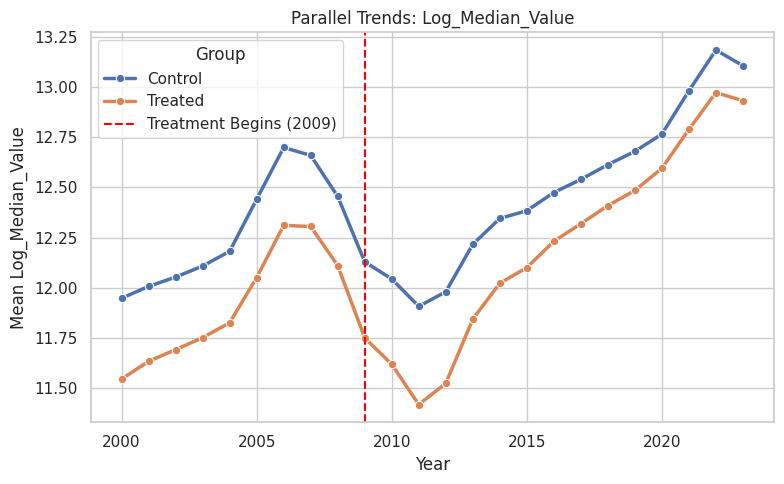

In [ ]:
sns.set(style="whitegrid")

# Configuration (Corrected Impl Year to 2009 for plot visualization)
outcome = 'Log_Median_Value'
impl_start_year = 2009 # First year of the Implementation Phase (2009-2016)
group_labels = {0: 'Control', 1: 'Treated'}

# Compute yearly averages by treatment group
trend_df = (
    df.groupby(['Year', 'Treatment_Group'])[outcome]
    .mean()
    .reset_index()
)
trend_df['Group'] = trend_df['Treatment_Group'].map(group_labels)

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=trend_df,
    x='Year',
    y=outcome,
    hue='Group',
    marker='o',
    linewidth=2.5
)

# Add vertical line for implementation start
plt.axvline(impl_start_year, color='red', linestyle='--', label=f'Treatment Begins ({impl_start_year})')

# Titles and labels
plt.title(f"Parallel Trends: {outcome}")
plt.xlabel("Year")
plt.ylabel(f"Mean {outcome}")
plt.legend(title='Group', loc='best')
plt.tight_layout()
plt.show()

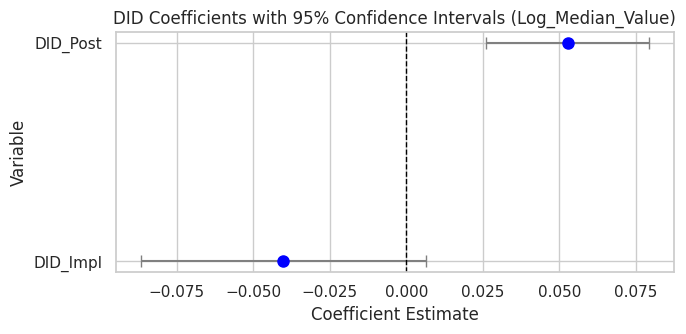

In [ ]:
# Extract coefficients and confidence intervals from the statsmodels result
coef = results_did['Log_Median_Value'].params
conf = results_did['Log_Median_Value'].conf_int()
conf.columns = ['CI_lower', 'CI_upper']

# Combine into one DataFrame
results = pd.concat([coef, conf], axis=1).reset_index()
results.columns = ['Variable', 'Coefficient', 'CI_lower', 'CI_upper']

# Filter to focus on DID variables only
did_results = results[results['Variable'].isin(['DID_Impl', 'DID_Post'])]

# Plot
plt.figure(figsize=(7, 3.5))
sns.set(style="whitegrid")

plt.errorbar(
    did_results['Coefficient'],
    did_results['Variable'],
    xerr=[
        did_results['Coefficient'] - did_results['CI_lower'],
        did_results['CI_upper'] - did_results['Coefficient']
    ],
    fmt='o', color='blue', ecolor='gray', capsize=4, markersize=8
)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title("DID Coefficients with 95% Confidence Intervals (Log_Median_Value)")
plt.xlabel("Coefficient Estimate")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()
did_results.to_csv("A1_Coefficients.csv", index=False)

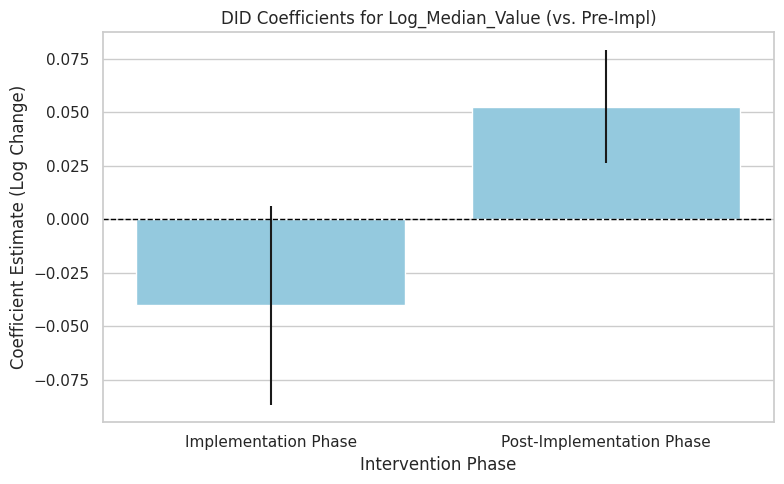

In [ ]:
sns.set(style="whitegrid")

res = results_did['Log_Median_Value'] # Use the Log_Median_Value result

# Prepare Data
did_vars = ['DID_Impl', 'DID_Post']
coef = res.params[did_vars]
conf = res.conf_int().loc[did_vars]
conf.columns = ['CI_lower', 'CI_upper']

did_results = pd.concat([coef, conf], axis=1).reset_index()
did_results.columns = ['Variable', 'Coefficient', 'CI_lower', 'CI_upper']

# Calculate error bar size
did_results['CI_error'] = did_results['CI_upper'] - did_results['Coefficient']
did_results['Variable'] = did_results['Variable'].replace({
    'DID_Impl': 'Implementation Phase',
    'DID_Post': 'Post-Implementation Phase'
})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    x='Variable',
    y='Coefficient',
    data=did_results,
    color='skyblue',
    # Use the calculated CI_error for the yerr argument in the bar plot
    yerr=did_results['CI_error'].values
)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("DID Coefficients for Log_Median_Value (vs. Pre-Impl)")
plt.xlabel("Intervention Phase")
plt.ylabel("Coefficient Estimate (Log Change)")
plt.tight_layout()
plt.show()

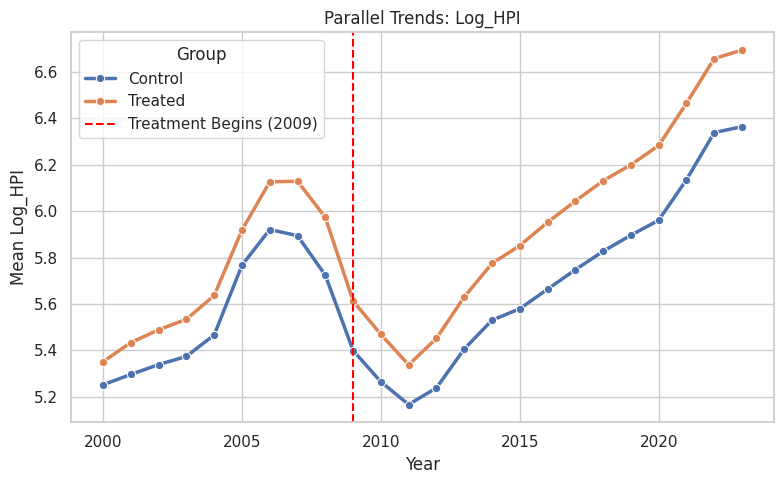

In [ ]:
sns.set(style="whitegrid")

# Configuration
outcome = 'Log_HPI'
impl_start_year = 2009
group_labels = {0: 'Control', 1: 'Treated'}

# Compute yearly averages by treatment group
trend_df = (
    df.groupby(['Year', 'Treatment_Group'])[outcome]
    .mean()
    .reset_index()
)
trend_df['Group'] = trend_df['Treatment_Group'].map(group_labels)

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=trend_df,
    x='Year',
    y=outcome,
    hue='Group',
    marker='o',
    linewidth=2.5
)

# Add vertical line for implementation start
plt.axvline(impl_start_year, color='red', linestyle='--', label=f'Treatment Begins ({impl_start_year})')

# Titles and labels
plt.title(f"Parallel Trends: {outcome}")
plt.xlabel("Year")
plt.ylabel(f"Mean {outcome}")
plt.legend(title='Group', loc='best')
plt.tight_layout()
plt.show()

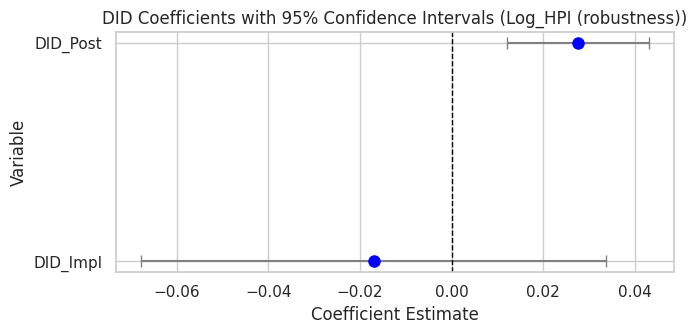

In [ ]:
# Extract coefficients and confidence intervals from the statsmodels result
coef = results_did['Log_HPI'].params
conf = results_did['Log_HPI'].conf_int()
conf.columns = ['CI_lower', 'CI_upper']

# Combine into one DataFrame
results = pd.concat([coef, conf], axis=1).reset_index()
results.columns = ['Variable', 'Coefficient', 'CI_lower', 'CI_upper']

# Filter to focus on DID variables only
did_results = results[results['Variable'].isin(['DID_Impl', 'DID_Post'])]

# Plot
plt.figure(figsize=(7, 3.5))
sns.set(style="whitegrid")

plt.errorbar(
    did_results['Coefficient'],
    did_results['Variable'],
    xerr=[
        did_results['Coefficient'] - did_results['CI_lower'],
        did_results['CI_upper'] - did_results['Coefficient']
    ],
    fmt='o', color='blue', ecolor='gray', capsize=4, markersize=8
)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title("DID Coefficients with 95% Confidence Intervals (Log_HPI (robustness))")
plt.xlabel("Coefficient Estimate")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()
did_results.to_csv("A2_Coefficients.csv", index=False)

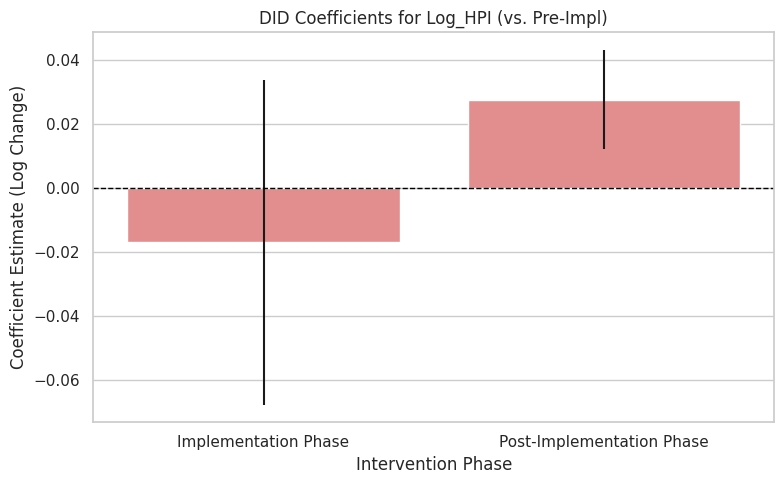

In [ ]:
sns.set(style="whitegrid")

res = results_did['Log_HPI']

# Prepare Data
did_vars = ['DID_Impl', 'DID_Post']
coef = res.params[did_vars]
conf = res.conf_int().loc[did_vars]
conf.columns = ['CI_lower', 'CI_upper']

did_results = pd.concat([coef, conf], axis=1).reset_index()
did_results.columns = ['Variable', 'Coefficient', 'CI_lower', 'CI_upper']

# Calculate error bar size
did_results['CI_error'] = did_results['CI_upper'] - did_results['Coefficient']
did_results['Variable'] = did_results['Variable'].replace({
    'DID_Impl': 'Implementation Phase',
    'DID_Post': 'Post-Implementation Phase'
})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    x='Variable',
    y='Coefficient',
    data=did_results,
    color='lightcoral',
    yerr=did_results['CI_error'].values
)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("DID Coefficients for Log_HPI (vs. Pre-Impl)")
plt.xlabel("Intervention Phase")
plt.ylabel("Coefficient Estimate (Log Change)")
plt.tight_layout()
plt.show()

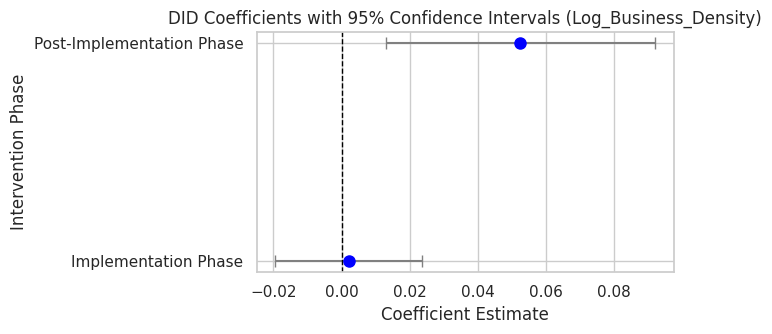

In [ ]:
# Extract coefficients and confidence intervals from the statsmodels result
coef = results_did['Log_Business_Density'].params
conf = results_did['Log_Business_Density'].conf_int()
conf.columns = ['CI_lower', 'CI_upper']

# Combine into one DataFrame
results = pd.concat([coef, conf], axis=1).reset_index()
results.columns = ['Variable', 'Coefficient', 'CI_lower', 'CI_upper']


# Filter to focus on DID variables only
did_results = results[results['Variable'].isin(['DID_Impl', 'DID_Post'])]

# Plot
plt.figure(figsize=(7, 3.5))
sns.set(style="whitegrid")

plt.errorbar(
    did_results['Coefficient'],
    did_results['Variable'],
    xerr=[
        did_results['Coefficient'] - did_results['CI_lower'],
        did_results['CI_upper'] - did_results['Coefficient']
    ],
    fmt='o', color='blue', ecolor='gray', capsize=4, markersize=8
)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title("DID Coefficients with 95% Confidence Intervals (Log_Business_Density)")
plt.xlabel("Coefficient Estimate")
plt.ylabel("Intervention Phase") # Changed label for clarity
plt.yticks([0, 1], ['Implementation Phase', 'Post-Implementation Phase']) # Map variable names to clearer labels
plt.tight_layout()
plt.show()
did_results.to_csv("B_Coefficients.csv", index=False)

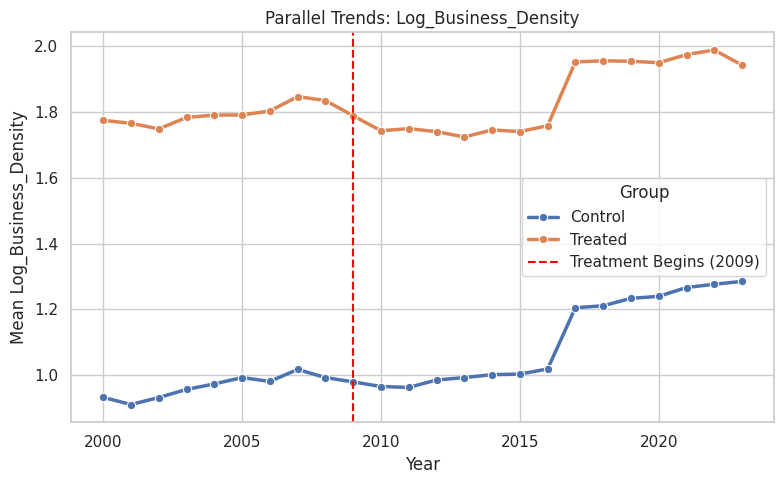

In [ ]:
sns.set(style="whitegrid")

# Configuration
outcome = 'Log_Business_Density'
impl_start_year = 2009
group_labels = {0: 'Control', 1: 'Treated'}

# Compute yearly averages by treatment group
trend_df = (
    df.groupby(['Year', 'Treatment_Group'])[outcome]
    .mean()
    .reset_index()
)
trend_df['Group'] = trend_df['Treatment_Group'].map(group_labels)

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=trend_df,
    x='Year',
    y=outcome,
    hue='Group',
    marker='o',
    linewidth=2.5
)

# Add vertical line for implementation start
plt.axvline(impl_start_year, color='red', linestyle='--', label=f'Treatment Begins ({impl_start_year})')

# Titles and labels
plt.title(f"Parallel Trends: {outcome}")
plt.xlabel("Year")
plt.ylabel(f"Mean {outcome}")
plt.legend(title='Group', loc='best')
plt.tight_layout()
plt.show()

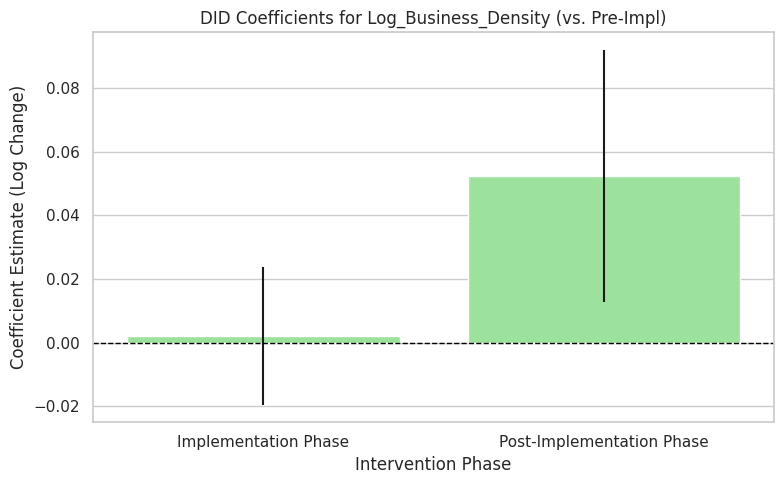

In [ ]:
sns.set(style="whitegrid")

res = results_did['Log_Business_Density'] # Use the Log_Business_Density result

# Prepare Data
did_vars = ['DID_Impl', 'DID_Post']
coef = res.params[did_vars]
conf = res.conf_int().loc[did_vars]
conf.columns = ['CI_lower', 'CI_upper']

did_results = pd.concat([coef, conf], axis=1).reset_index()
did_results.columns = ['Variable', 'Coefficient', 'CI_lower', 'CI_upper']

# Calculate error bar size
did_results['CI_error'] = did_results['CI_upper'] - did_results['Coefficient']
did_results['Variable'] = did_results['Variable'].replace({
    'DID_Impl': 'Implementation Phase',
    'DID_Post': 'Post-Implementation Phase'
})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    x='Variable',
    y='Coefficient',
    data=did_results,
    color='lightgreen',
    yerr=did_results['CI_error'].values
)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("DID Coefficients for Log_Business_Density (vs. Pre-Impl)")
plt.xlabel("Intervention Phase")
plt.ylabel("Coefficient Estimate (Log Change)")
plt.tight_layout()
plt.show()

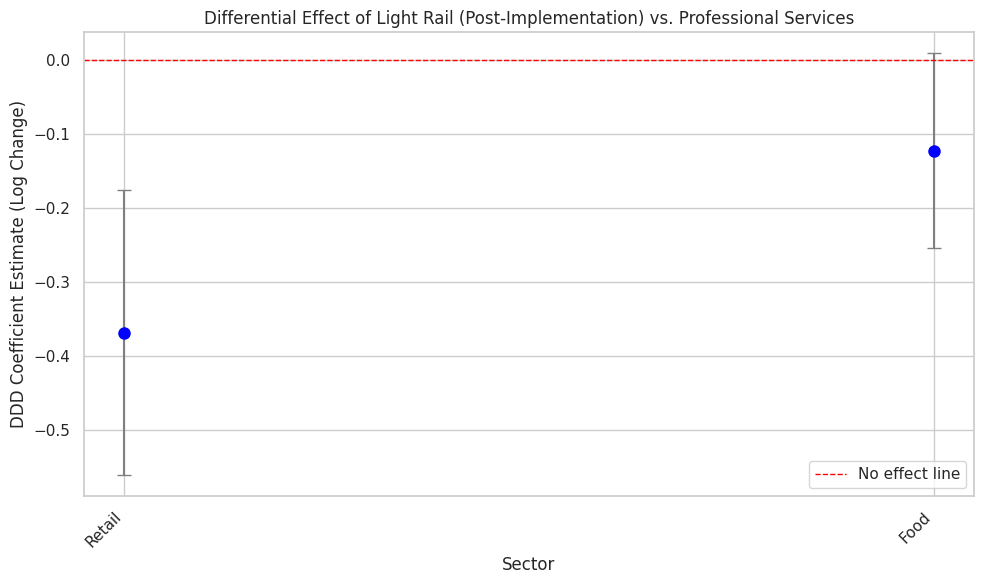

In [ ]:
# Define the relevant DDD terms for the POST phase
post_ddd_terms = ['DDD_Retail_Post', 'DDD_Food_Post']

# Extract coefficients and confidence intervals from the result object (res_h1d)
coef = res_h1d.params[post_ddd_terms]
conf = res_h1d.conf_int().loc[post_ddd_terms]
conf.columns = ['CI_lower', 'CI_upper']
bse = res_h1d.bse[post_ddd_terms]

#Combine into a single DataFrame for plotting
ddd_post_results = pd.concat([coef, conf, bse], axis=1).reset_index()
ddd_post_results.columns = ['Term', 'Coefficient', 'CI_lower', 'CI_upper', 'StdErr']

# Clean up names for better plotting labels
ddd_post_results['Sector'] = ddd_post_results['Term'].str.replace('DDD_', '').str.replace('_Post', '').str.replace('_', ' ')

# Calculate error bar size (difference between coefficient and CI bounds)
ddd_post_results['Error_Size'] = ddd_post_results['CI_upper'] - ddd_post_results['Coefficient']

#Plot the results
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Use plt.errorbar to create the scatter plot with CIs
plt.errorbar(
    ddd_post_results['Sector'],
    ddd_post_results['Coefficient'],
    # xerr: horizontal error, yerr: vertical error
    yerr=[
        ddd_post_results['Coefficient'] - ddd_post_results['CI_lower'],
        ddd_post_results['CI_upper'] - ddd_post_results['Coefficient']
    ],
    fmt='o',
    capsize=5,
    color='blue',
    ecolor='gray',
    markersize=8
)

plt.axhline(0, color='red', linestyle='--', linewidth=1, label='No effect line')
plt.xticks(rotation=45, ha='right')
plt.title('Differential Effect of Light Rail (Post-Implementation) vs. Professional Services')
plt.ylabel('DDD Coefficient Estimate (Log Change)')
plt.xlabel('Sector')
plt.legend()
plt.tight_layout()
plt.show()

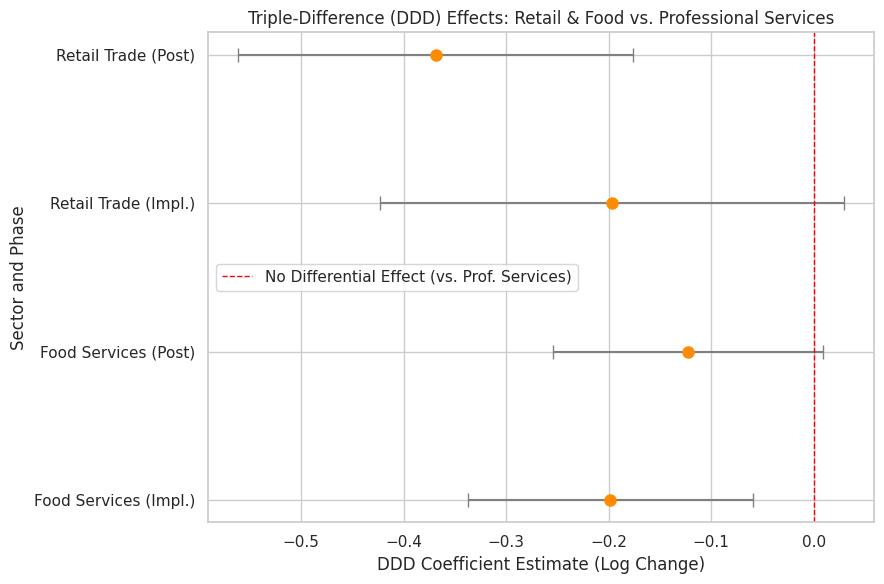

In [ ]:
#Define ALL relevant DDD terms
all_ddd_terms = ['DDD_Retail_Impl', 'DDD_Retail_Post', 'DDD_Food_Impl', 'DDD_Food_Post']

#Extract and Combine Data
coef = res_h1d.params[all_ddd_terms]
conf = res_h1d.conf_int().loc[all_ddd_terms]
conf.columns = ['CI_lower', 'CI_upper']

ddd_full_results = pd.concat([coef, conf], axis=1).reset_index()
ddd_full_results.columns = ['Term', 'Coefficient', 'CI_lower', 'CI_upper']

# Create Categorical Variables for Plotting
ddd_full_results['Sector'] = ddd_full_results['Term'].str.split('_').str[1]
ddd_full_results['Phase'] = ddd_full_results['Term'].str.split('_').str[2]
ddd_full_results['Label'] = ddd_full_results['Sector'] + ' (' + ddd_full_results['Phase'] + ')'

# Map to clean names
ddd_full_results['Label'] = ddd_full_results['Label'].replace({
    'Retail (Impl)': 'Retail Trade (Impl.)',
    'Retail (Post)': 'Retail Trade (Post)',
    'Food (Impl)': 'Food Services (Impl.)',
    'Food (Post)': 'Food Services (Post)'
})

# Sort for better plotting order
ddd_full_results = ddd_full_results.sort_values(by=['Sector', 'Phase'], ascending=[True, True])

# Plot
plt.figure(figsize=(9, 6))
sns.set_style("whitegrid")

# Use horizontal error bars (Forest Plot Style)
plt.errorbar(
    x=ddd_full_results['Coefficient'],
    y=ddd_full_results['Label'],
    xerr=[
        ddd_full_results['Coefficient'] - ddd_full_results['CI_lower'],
        ddd_full_results['CI_upper'] - ddd_full_results['Coefficient']
    ],
    fmt='o',
    capsize=5,
    color='darkorange',
    ecolor='grey',
    markersize=8
)

plt.axvline(0, color='red', linestyle='--', linewidth=1, label='No Differential Effect (vs. Prof. Services)')

plt.title('Triple-Difference (DDD) Effects: Retail & Food vs. Professional Services')
plt.xlabel('DDD Coefficient Estimate (Log Change)')
plt.ylabel('Sector and Phase')
plt.legend()
plt.tight_layout()
plt.show()

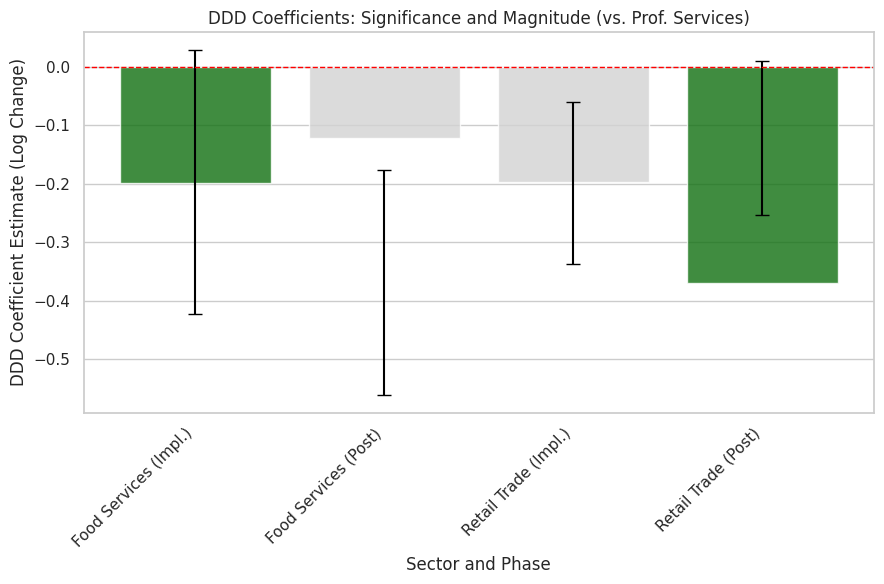

In [ ]:
# Determine significance (p-value check required, but for plotting, we can use CI bounds)
# Significant if CI does NOT cross zero
ddd_full_results['Significant'] = ((ddd_full_results['CI_lower'] > 0) | (ddd_full_results['CI_upper'] < 0))

plt.figure(figsize=(9, 6))
sns.set_style("whitegrid")

# Plot using Seaborn Barplot, with hue to distinguish phases
ax = sns.barplot(
    x='Label',
    y='Coefficient',
    hue='Significant',
    data=ddd_full_results,
    palette={True: 'green', False: 'lightgray'},
    dodge=False,
    alpha=0.8
)

# Overlay error bars (CI)
for index, row in ddd_full_results.iterrows():
    ax.errorbar(
        index,
        row['Coefficient'],
        yerr=[[row['Coefficient'] - row['CI_lower']], [row['CI_upper'] - row['Coefficient']]],
        fmt='none',
        capsize=5,
        color='black'
    )

plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('DDD Coefficients: Significance and Magnitude (vs. Prof. Services)')
plt.ylabel('DDD Coefficient Estimate (Log Change)')
plt.xlabel('Sector and Phase')
plt.xticks(rotation=45, ha='right')

# Remove the significance legend
ax.legend_.remove()
plt.tight_layout()
plt.show()

In [ ]:
def save_model_summary_to_csv(res, filename, cluster_col='ZIP'):
    """
    Extracts key results (coef, std err, p-value, CIs) from a statsmodels
    result object and saves them to a CSV file.
    """
    # Extract the core summary table
    results_df = pd.DataFrame({
        'Coefficient': res.params,
        'Std_Error': res.bse,
        'P_Value': res.pvalues
    })

    # Add 95% Confidence Intervals
    conf_int = res.conf_int()
    results_df['CI_Lower_95'] = conf_int.iloc[:, 0]
    results_df['CI_Upper_95'] = conf_int.iloc[:, 1]

    # Reset index to make the variable name a column
    results_df = results_df.reset_index().rename(columns={'index': 'Variable'})

    #  Add model information (optional but helpful)
    results_df['R_Squared'] = res.rsquared
    results_df['Num_Observations'] = res.nobs
    results_df['Cluster_Variable'] = cluster_col # Assuming clustering by ZIP

    # Save the DataFrame to CSV
    results_df.to_csv(filename, index=False)

In [ ]:
save_model_summary_to_csv(results_did['Log_Median_Value'], 'Log_Median_Value_DID_Summary.csv')

In [ ]:
save_model_summary_to_csv(results_did['Log_HPI'], 'Log_Hpi_DID_Summary.csv')

In [ ]:
save_model_summary_to_csv(results_did['Log_Business_Density'], 'Business_density_Value_DID_Summary.csv')

In [ ]:
def plot_event_study(res, title, omitted_year=-1, color='blue'):
    """Plots the coefficients from a dynamic DID (Event Study) model."""
    # Find terms, accounting for Patsy's Q() quoting
    event_terms = [col for col in res.params.index if col.startswith('Q("Event_')]

    plot_df = pd.DataFrame({
        'Coefficient': res.params.loc[event_terms],
        'CI_lower': res.conf_int().loc[event_terms, 0],
        'CI_upper': res.conf_int().loc[event_terms, 1]
    }).reset_index()

    # Extract the relative year from the quoted term name: Q("Event_X") -> X
    plot_df['Rel_Year'] = plot_df['index'].str.extract(r'Q\("Event_([-\d]+)"\)').astype(int)

    # Insert the omitted year (baseline)
    omitted_data = pd.DataFrame({'Rel_Year': [omitted_year], 'Coefficient': [0.0], 'CI_lower': [0.0], 'CI_upper': [0.0]})
    plot_df = pd.concat([plot_df, omitted_data], ignore_index=True)
    plot_df = plot_df.sort_values(by='Rel_Year').reset_index(drop=True)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    plt.errorbar(
        plot_df['Rel_Year'],
        plot_df['Coefficient'],
        yerr=[
            plot_df['Coefficient'] - plot_df['CI_lower'],
            plot_df['CI_upper'] - plot_df['Coefficient']
        ],
        fmt='o', color=color, ecolor='gray', capsize=4, markersize=6
    )

    # Add lines for reference and treatment start
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.axvline(omitted_year, color='green', linestyle=':', label=f'Omitted Baseline ({impl_start_year + omitted_year})')
    plt.axvline(omitted_year + 1, color='orange', linestyle='-', linewidth=1, label=f'Treatment Start ({impl_start_year})')

    plt.title(f'Dynamic DID (Event Study): {title}')
    plt.xlabel('Years Relative to Treatment Start (2009)')
    plt.ylabel('Coefficient (Change in Log Value)')
    plt.legend()
    plt.tight_layout()
    plt.show()


 Dynamic DID (Event Study)

=== Dynamic DID Results: Log_Median_Value ===


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 165, but rank is 44
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:       Log_Median_Value   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 3.574e+04
Date:                Fri, 14 Nov 2025   Prob (F-statistic):          2.63e-223
Time:                        00:30:00   Log-Likelihood:                 42391.
No. Observations:               45196   AIC:                        -8.445e+04
Df Residuals:                   45032   BIC:                        -8.302e+04
Df Model:                         163                                         
Covariance Type:              cluster                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               12.0894 

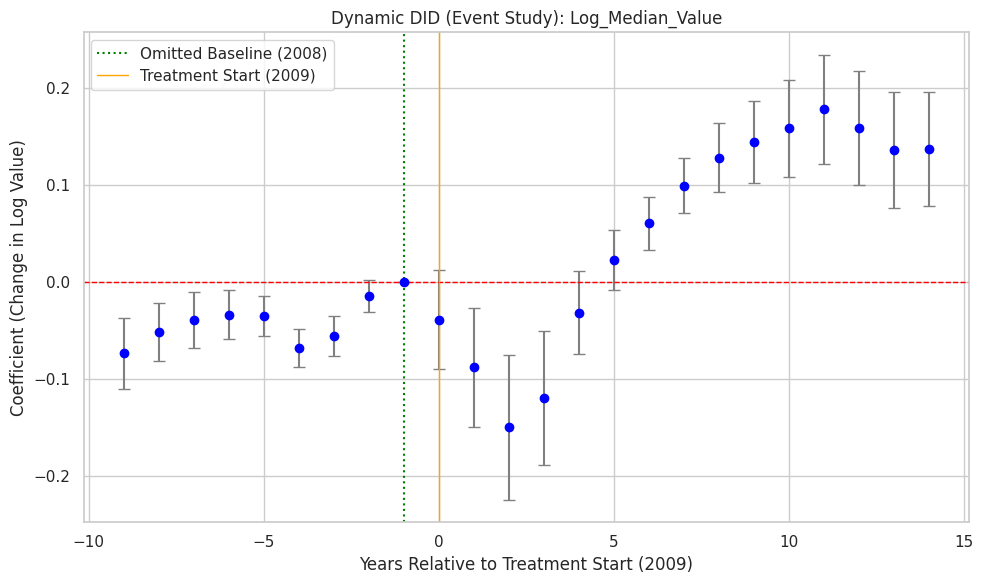


=== Dynamic DID Results: Log_HPI ===
                            OLS Regression Results                            
Dep. Variable:                Log_HPI   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                 2.814e+04
Date:                Fri, 14 Nov 2025   Prob (F-statistic):          3.11e-217
Time:                        00:30:03   Log-Likelihood:                 45471.
No. Observations:               45196   AIC:                        -9.061e+04
Df Residuals:                   45032   BIC:                        -8.918e+04
Df Model:                         163                                         
Covariance Type:              cluster                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 165, but rank is 44
  warnings.warn('covariance of constraints does not have full '


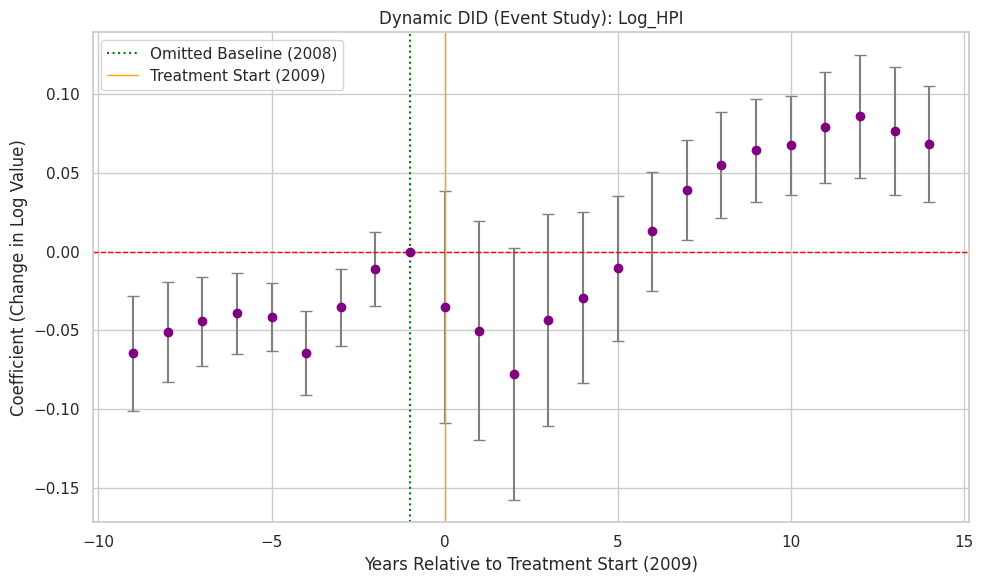


=== Dynamic DID Results: Log_Business_Density ===


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 165, but rank is 44
  warnings.warn('covariance of constraints does not have full '


                             OLS Regression Results                             
Dep. Variable:     Log_Business_Density   R-squared:                       0.445
Model:                              OLS   Adj. R-squared:                  0.443
Method:                   Least Squares   F-statistic:                     3729.
Date:                  Fri, 14 Nov 2025   Prob (F-statistic):          6.68e-166
Time:                          00:30:09   Log-Likelihood:                -49271.
No. Observations:                 45196   AIC:                         9.887e+04
Df Residuals:                     45032   BIC:                         1.003e+05
Df Model:                           163                                         
Covariance Type:                cluster                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept   

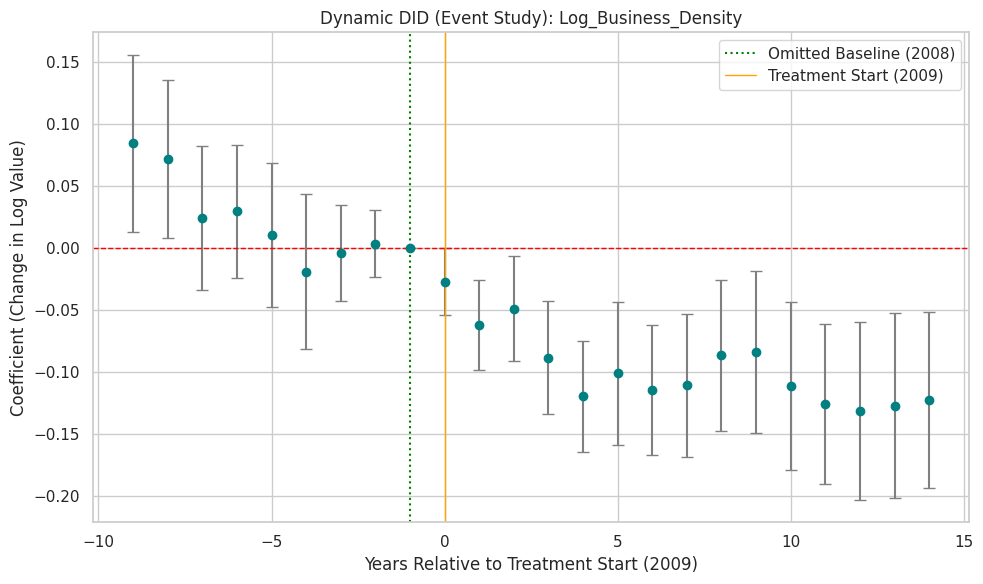

In [ ]:
treatment_year = 2009
omitted_year = -1
df['Rel_Year'] = df['Year'] - treatment_year
formula_terms = []

for year in sorted(df['Rel_Year'].unique()):
    if year != omitted_year:
        col_name = f'Event_{year}'
        df[f'Rel_Year_{year}'] = (df['Rel_Year'] == year).astype(int)
        df[col_name] = df[f'Rel_Year_{year}'] * df['Treatment_Group']
        # Use Q() for Patsy to handle negative years
        formula_terms.append(f'Q("{col_name}")')

event_terms_formula = ' + '.join(formula_terms)
dynamic_base_formula = f'{event_terms_formula} + {controls} + C(ZIP) + C(Year)'

# Dynamic DID Model Fitting and Plotting
dynamic_outcomes = {
    'Log_Median_Value': 'blue',
    'Log_HPI': 'purple',
    'Log_Business_Density': 'teal'
}

print("\n Dynamic DID (Event Study)")
for dep_var, color in dynamic_outcomes.items():
    dynamic_formula = f'{dep_var} ~ {dynamic_base_formula}'
    res_dynamic = fit_ols_cluster(dynamic_formula, df)
    print(f"\nDynamic DID Results: {dep_var} ===")
    print(res_dynamic.summary())
    plot_event_study(res_dynamic, dep_var, color=color)